In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
import os
import numpy as np
import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from typing import List
from tqdm import tqdm

## Model and DataLoader Files

In [3]:
class SpatialSoftmax(torch.nn.Module):
    def __init__(self, height, width, channel, temperature=None, data_format='NCHW'):
        super(SpatialSoftmax, self).__init__()
        self.data_format = data_format
        self.height = height
        self.width = width
        self.channel = channel

        if temperature:
            self.temperature = torch.nn.Parameter(torch.ones(1)*temperature)
        else:
            self.temperature = 1.

        pos_x, pos_y = np.meshgrid(
                np.linspace(-1., 1., self.height),
                np.linspace(-1., 1., self.width)
                )
        pos_x = torch.from_numpy(pos_x.reshape(self.height*self.width)).float()
        pos_y = torch.from_numpy(pos_y.reshape(self.height*self.width)).float()
        self.register_buffer('pos_x', pos_x)
        self.register_buffer('pos_y', pos_y)

    def forward(self, feature):
        if self.data_format == 'NHWC':
            feature = feature.transpose(1, 3).tranpose(2, 3).view(-1, self.height*self.width)
        else:
            feature = feature.view(-1, self.height*self.width)
        
        softmax_attention = F.softmax(feature/self.temperature, dim=-1)
        expected_x = torch.sum(self.pos_x*softmax_attention, dim=1, keepdim=True)
        expected_y = torch.sum(self.pos_y*softmax_attention, dim=1, keepdim=True)
        expected_xy = torch.cat([expected_x, expected_y], 1)
        feature_keypoints = expected_xy.view(-1, self.channel*2)

        return feature_keypoints

#Implementation of Network from Figure 3 (on pg 4) of paper
class VRNet(nn.Module):
    def __init__(self):
        super(VRNet, self).__init__()
        # Convolution 1 160x120x3 -> 77x57x64
        # self.conv1_rgb = nn.Conv2d(3, 64, 7, padding='valid', stride=2)
        self.conv1_rgb = nn.Conv2d(3, 64, 7, padding='valid', stride=2)

        # Convolution 2 77x57x64 -> 77x57x32
        self.conv2 = nn.Conv2d(64, 32, 1, padding='same')
        self.conv2_bn = nn.BatchNorm2d(32, eps=0.001, momentum=0.99)
        # Convolution 3 77x57x32 -> 75x55x32
        self.conv3 = nn.Conv2d(32, 32, 3, padding='valid')
        self.conv3_bn = nn.BatchNorm2d(32, eps=0.001, momentum=0.99)
        # Convolution 4 75x55x32 -> 73x53x32
        self.conv4 = nn.Conv2d(32, 32, 3, padding='valid')
        self.conv4_bn = nn.BatchNorm2d(32, eps=0.001, momentum=0.99)

        # spatial softmax
        # self.spatialSoftmax = SpatialSoftmax(53, 73, 32, temperature=1, data_format='NCHW')
        self.spatialSoftmax = SpatialSoftmax(193, 293, 32, temperature=1, data_format='NCHW')

        self.flatten = nn.Flatten()

        #fully connected layers
        self.fc1 = nn.Linear(64, 50)
        self.fc1_bn = nn.BatchNorm1d(50, eps=0.001, momentum=0.99)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_bn = nn.BatchNorm1d(50, eps=0.001, momentum=0.99)
        self.fc3 = nn.Linear(50, 50)
        self.fc3_bn = nn.BatchNorm1d(50, eps=0.001, momentum=0.99)
        # self.fc4 = nn.Linear(50, 7) # Vx, Vy, Vz, Wx, Wy, Wz, grabber open
        self.fc4 = nn.Linear(50, 1)

        #set conv1_rgb weights to be first layer from pretrained model
        googlenet = torchvision.models.googlenet(pretrained=True)
        self.conv1_rgb.weight.data = googlenet.conv1.conv.weight.data

        #weights should be uniformly sampled from [-0.1, 0.1]
        self.conv2.weight.data.uniform_(-0.1, 0.1)
        self.conv3.weight.data.uniform_(-0.1, 0.1)
        self.conv4.weight.data.uniform_(-0.1, 0.1)

        self.fc1.weight.data.uniform_(-0.1, 0.1)
        self.fc2.weight.data.uniform_(-0.1, 0.1)
        self.fc3.weight.data.uniform_(-0.1, 0.1)
        self.fc4.weight.data.uniform_(-0.1, 0.1)


    # ADDED by Sandra # 20230314 - uses the batch normalization:
    def forward(self, rgbImg):

        # Convolution 1 160x120x3 -> 77x57x64
        x = self.conv1_rgb(rgbImg)
        x = F.relu(x)

        # print_output("conv1_rgb_shape: " + str(x.shape))
        # print("conv1_rgb_shape:", x.shape)

        # Convolution 2 77x57x64 -> 77x57x32
        # x = self.conv2_bn(self.conv2(x))
        # x = F.relu(self.conv2_bn(x))
        x = self.conv2(x)
        # print_output("conv2_shape: " + str(x.shape))
        x = F.relu(self.conv2_bn(x))
        # print_output("conv2_bn_shape: " + str(x.shape))

        # Convolution 3 77x57x32 -> 75x55x32
        x = self.conv3(x)
        # print_output("conv3_shape: " + str(x.shape))
        x = F.relu(self.conv3_bn(x))
        # print_output("conv3_bn_shape: " + str(x.shape))

        # Convolution 4 75x55x32 -> 73x53x32
        # x = self.conv4(x)
        # x = F.relu(self.conv4_bn(x))
        x = self.conv4(x)
        # print_output("conv4_shape: " + str(x.shape))
        x = F.relu(self.conv4_bn(x))
        # print_output("conv4_bn_shape:"+ str(x.shape))

        # spatial softmax
        x = self.spatialSoftmax(x)
        # print_output("spatialSoftmax_shape:"+ str(x.shape))
        

        x = self.flatten(x)
        # print_output("flatten_shape:" + str(x.shape))

        # Fully connected layers
        x = F.relu(self.fc1(x))
        # print_output("fc1_shape:" + str(x.shape))
        # x = F.relu(self.fc1_bn(x))
        # print_output("fc1_bn_shape:" + x.shape)
        x = F.relu(self.fc2(x))
        # print_output("fc2_shape:" + str(x.shape))
        # x = F.relu(self.fc2_bn(x))
        # print_output("fc2_bn_shape:" + str(x.shape))
        x = F.relu(self.fc3(x))
        # print_output("fc3_shape:" + str(x.shape))
        # x = F.relu(self.fc3_bn(x))
        # print_output("fc3_bn_shape:" + str(x.shape))

        # Output layer
        x = self.fc4(x)
        # print_output("fc4_shape:" + str(x.shape))

        return x


class DataLoader(Dataset):

    def __init__(self, data_dir: str, episode_list: List, samples: int, batch_size=1):
        self.data_dir = data_dir
        self.episode_list = episode_list # number of episodes
        self.samples = samples # number of samples in each episode
        self.batch_size = batch_size
        self.rgb_images, self.actions = self.load_data() # Changed - Sandra 10/04 - 7:50pm states to actions
        self.arrayIndicies = list([i for i in range(len(self.rgb_images))])
        print(len(self.rgb_images), len(self.actions))
        assert(len(self.rgb_images) == len(self.actions))
    
    # train_data_loader function - by Sandra
    # Output: rgbs list and action list

    def load_data(self):
        """Loads data from the data directory and returns a list of rgb images and a list of actions"""
        rgbs = []
        actions = []
        
        for i in self.episode_list:
            episode_number = str(i)
            print(f"Loading episode {episode_number}")

            episode_dir = os.path.join(self.data_dir, r"episode-" + episode_number)
            episode_info_df = pd.read_csv(os.path.join(episode_dir, r"episode-" + episode_number +".csv"))
            episode_actions = episode_info_df["Action"].iloc[0:self.samples].tolist() # Changed - by Sandra 10/04 - 7:13pm
            
            for j in range(self.samples):
                sample_number = str(j + 1)
                # if int(sample_number) < 10:
                #     zero_prefix = "00"
                # elif int(sample_number) < 100:
                #     zero_prefix = "0"
                # else:
                #     zero_prefix = ""
                
                rgb_path = os.path.join(episode_dir, "episode-" + episode_number + "-" + f"{j+1:03d}" + ".png")
                # rgb_path = os.path.join(episode_dir, "episode-" + episode_number + "-" + zero_prefix + sample_number+ ".png")

                rgb_image = torchvision.io.read_image(rgb_path)
                rgbs.append(rgb_image)
            actions = actions + episode_actions # Changed - by Sandra 10/04 - 7:13pm
        
        # Preprocessing rgbs
        rgbs = torch.stack(rgbs).float() / 255
        rgb_mean = torch.mean(rgbs, dim=(0, 2, 3))
        
        # #compute std
        # rgb_std = torch.std(rgbs, dim=(0, 2, 3))
        # #normalize images
        # rgbs[:,0,:,:] = (rgbs[:,0,:,:] - rgb_mean[0]) / rgb_std[0]
        # rgbs[:,1,:,:] = (rgbs[:,1,:,:] - rgb_mean[0]) / rgb_std[1]
        # rgbs[:,2,:,:] = (rgbs[:,2,:,:] - rgb_mean[0]) / rgb_std[2]

        # Modified by Sandra - 20230413 - to ensure data does not contain nan or infinite values
        epsilon = 1e-6
        rgb_std = torch.std(rgbs, dim=(0, 2, 3)) + epsilon
        # rgb_std = torch.std(rgbs, dim=(0, 2, 3))
        rgbs[:,0,:,:] = (rgbs[:,0,:,:] - rgb_mean[0]) / rgb_std[0]
        rgbs[:,1,:,:] = (rgbs[:,1,:,:] - rgb_mean[0]) / rgb_std[1]
        rgbs[:,2,:,:] = (rgbs[:,2,:,:] - rgb_mean[0]) / rgb_std[2]
        #-------
        
        return rgbs, actions
    
    def __len__(self):
        return len(self.actions) // self.batch_size # changed - Sandra - states to actions

    def __getitem__(self, idx):
        #shuffle array index mapping
        # if idx == 0:
        np.random.seed(103)
        np.random.shuffle(self.arrayIndicies)
            
        idx = idx * self.batch_size
        desiredIndexes = self.arrayIndicies[idx:idx+self.batch_size]

        rgb_img = []
        action = []
        
        for i in desiredIndexes:
            rgb_img.append(self.rgb_images[i])
            action.append(self.actions[i])

        rgb_img = torch.stack(rgb_img)
        # action = torch.stack(action)
        action = torch.FloatTensor(action)
        # action = torch.tensor(action)  
        action = action.view(1, -1) 

        return rgb_img, action

## Test Accuracy

In [4]:
def get_train_accuracy(model_path):
    data_dir = "data/simulated-samples/"
    data_loader = DataLoader(data_dir=data_dir, episode_list=[0,1,2,3,4], samples=499)
    
    loaded_model = VRNet()
    if torch.cuda.is_available():
        print("Using GPU")
        device = torch.device('cuda:0')
    else:
        print("Using CPU")
        device = torch.device('cpu')
    
    loaded_model.load_state_dict(torch.load(model_path, map_location=device))

    loaded_model.to(device) # move model to GPU

    if(loaded_model == None):
        raise("Loaded model is empty")

    num_of_predictions = 0
    correct_number_of_predictions = 0

    for i in tqdm(range(len(data_loader))):
        rgb_img, action = data_loader[i]

        rgb_img = rgb_img.to(device).float()
        target_action = action.to(device).float()
        
        output = loaded_model(rgb_img)
        # Apply sigmoid activation
        predicted_probs = torch.sigmoid(output)
        predicted_action = (predicted_probs > 0.5).float()

        if torch.equal(predicted_action, target_action):
            correct_number_of_predictions += 1
    
        num_of_predictions += 1

    accuracy = (correct_number_of_predictions/num_of_predictions) * 100 
    return accuracy

In [5]:
def get_test_accuracy(model_path):
    data_dir = "data/simulated-samples/"
    data_loader = DataLoader(data_dir=data_dir, episode_list=[5,6], samples=499)
    
    loaded_model = VRNet()
    if torch.cuda.is_available():
        print("Using GPU")
        device = torch.device('cuda:0')
    else:
        print("Using CPU")
        device = torch.device('cpu')
        
    loaded_model.load_state_dict(torch.load(model_path, map_location=device))

    loaded_model.to(device) # move model to GPU

    if(loaded_model == None):
        raise("Loaded model is empty")

    num_of_predictions = 0
    correct_number_of_predictions = 0

    for i in tqdm(range(len(data_loader))):
        rgb_img, action = data_loader[i]

        rgb_img = rgb_img.to(device).float()
        target_action = action.to(device).float()
        
        output = loaded_model(rgb_img)
        # Apply sigmoid activation
        predicted_probs = torch.sigmoid(output)
        predicted_action = (predicted_probs > 0.5).float()

        if torch.equal(predicted_action, target_action):
            correct_number_of_predictions += 1
    
        num_of_predictions += 1

    accuracy = (correct_number_of_predictions/num_of_predictions) * 100 
    return accuracy

In [6]:
def load_pickle(file_path):
    with open(file_path + ".pkl", 'rb') as f:
        history = pickle.load(f)
    return history

# Training and Testing Accuracies of model

Model 1

In [48]:
model_name = "model-23-04-16-v2"

history = load_pickle(model_name + ".pkl")
print("Config:", history["config"])
print("Final Training Loss:", history["loss"][-1])

print("Train Accuracy:", get_train_accuracy(model_name + ".pth"))
print("Test Accuracy:", get_test_accuracy(model_name + ".pth"))

Config: {'num_epochs': 50, 'learning_rate': 1e-05, 'optimizer': 'adam'}
Final Training Loss: 0.1284046173095703
Loading episode 0
Loading episode 1
Loading episode 2
Loading episode 3
Loading episode 4


C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2495 2495
Using GPU


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2495/2495 [00:07<00:00, 351.17it/s]


Train Accuracy: 50.06012024048096
Loading episode 5
Loading episode 6


C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


998 998
Using GPU


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [00:03<00:00, 323.30it/s]


Test Accuracy: 51.00200400801603


Model 2

In [49]:
model_name = "model-23-04-16-v3"

history = load_pickle(model_name + ".pkl")
print("Config:", history["config"])
print("Final Training Loss:", history["loss"][-1])

print("Train Accuracy:", get_train_accuracy(model_name + ".pth"))
print("Test Accuracy:", get_test_accuracy(model_name + ".pth"))

Config: {'num_epochs': 50, 'learning_rate': 1e-06, 'optimizer': 'adam'}
Final Training Loss: 0.7116307616233826
Loading episode 0
Loading episode 1
Loading episode 2
Loading episode 3
Loading episode 4


C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2495 2495
Using GPU


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2495/2495 [00:06<00:00, 365.76it/s]


Train Accuracy: 50.300601202404806
Loading episode 5
Loading episode 6


C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


998 998
Using GPU


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [00:02<00:00, 347.85it/s]


Test Accuracy: 50.50100200400801


Model 3

In [47]:
model_name = "model-23-04-16-v4"

history = load_pickle(model_name + ".pkl")
print("Config:", history["config"])
print("Final Training Loss:", history["loss"][-1])

print("Train Accuracy:", get_train_accuracy(model_name + ".pth"))
print("Test Accuracy:", get_test_accuracy(model_name + ".pth"))

Config: {'num_epochs': 50, 'learning_rate': 5e-06, 'optimizer': 'adam'}
Final Training Loss: 0.19330962002277374
Loading episode 0
Loading episode 1
Loading episode 2
Loading episode 3
Loading episode 4


C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2495 2495
Using GPU


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2495/2495 [00:07<00:00, 354.63it/s]


Train Accuracy: 77.875751503006
Loading episode 5
Loading episode 6


C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michelle\Documents\dev\ai-capstone-prj\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


998 998
Using GPU


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [00:03<00:00, 324.83it/s]


Test Accuracy: 70.04008016032064


## Loss Plot

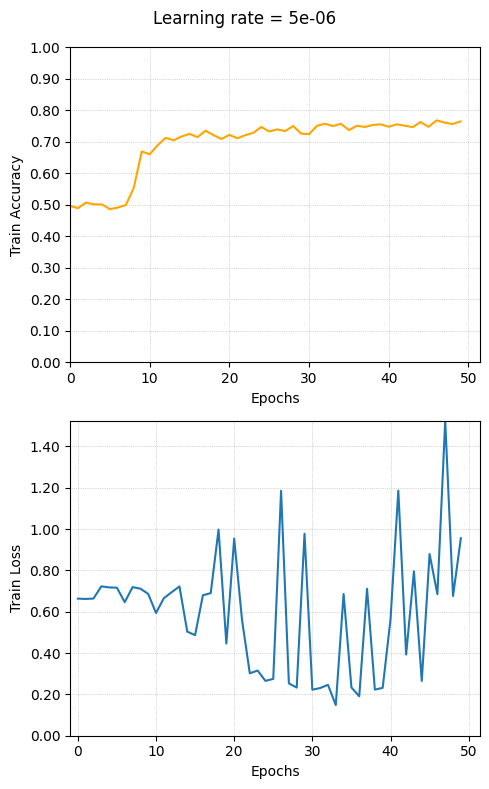

In [10]:
EPOCHS = 50
BATCH_SIZE = 4
OPTIMIZER = "adam"
LOSS_FUNCTION = "bce"

LEARNING_RATE = 5e-05  
m1 = f"model_ep-{EPOCHS}_lr-{str(LEARNING_RATE)}_bs-{BATCH_SIZE}_opt-{OPTIMIZER}_loss-{LOSS_FUNCTION}"

LEARNING_RATE = 1e-05
m2 = f"model_ep-{EPOCHS}_lr-{str(LEARNING_RATE)}_bs-{BATCH_SIZE}_opt-{OPTIMIZER}_loss-{LOSS_FUNCTION}"

LEARNING_RATE = 5e-06
m3 = f"model_ep-{EPOCHS}_lr-{str(LEARNING_RATE)}_bs-{BATCH_SIZE}_opt-{OPTIMIZER}_loss-{LOSS_FUNCTION}"

LEARNING_RATE = 1e-06
m4 = f"model_ep-{EPOCHS}_lr-{str(LEARNING_RATE)}_bs-{BATCH_SIZE}_opt-{OPTIMIZER}_loss-{LOSS_FUNCTION}"


history1 = load_pickle(m1)
history2 = load_pickle(m2)
history3 = load_pickle(m3)
history4 = load_pickle(m4)

history = history3
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,8))
plt.suptitle(f"Learning rate = 5e-06", x=0.5, ha="center")

ax[0].plot(history["train_acc"], color='orange')
ax[0].set_xlim(left=0)
ax[0].set_ylim(bottom=0, top=1)
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].set_yticklabels(['{:.2f}'.format(tick) for tick in ax[0].get_yticks()])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Train Accuracy")
ax[0].grid(True, linestyle=":", linewidth=0.5)

ax[1].plot(history["train_loss"])
ax[1].set_xlim(left=0-1)
ax[1].set_ylim(bottom=0, top=max(1, max(history["train_loss"])))
ax[1].set_yticks(np.arange(0, max(1, max(history["train_loss"])), 0.2))
ax[1].set_yticklabels(['{:.2f}'.format(tick) for tick in ax[1].get_yticks()])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Train Loss")
ax[1].grid(True, linestyle=":", linewidth=0.5)

plt.tight_layout()
plt.show()

In [18]:
print("Model 1:", history2["train_acc"][-1])
print("Model 2:", history4["train_acc"][-1])
print("Model 3:", history3["train_acc"][-1])

Model 1: 0.7709705124534784
Model 2: 0.6744918408245062
Model 3: 0.7652447752648154


In [19]:
print("Model 1:", history2["train_loss"][-1])
print("Model 2:", history4["train_loss"][-1])
print("Model 3:", history3["train_loss"][-1])

Model 1: 0.835905909538269
Model 2: 0.6997479200363159
Model 3: 0.9557111263275146


In [20]:
print("Model 1:", min(history2["train_loss"]))
print("Model 2:", min(history4["train_loss"]))
print("Model 3:", min(history3["train_loss"]))

Model 1: 0.051532141864299774
Model 2: 0.6501721739768982
Model 3: 0.14837999641895294
